<a href="https://colab.research.google.com/github/gyhou/DS-Unit-1-Sprint-3-Statistical-Tests-and-Experiments/blob/master/LS_DS_142_Sampling_Confidence_Intervals_and_Hypothesis_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science Module 142
## Sampling, Confidence Intervals, and Hypothesis Testing

## Prepare - examine other available hypothesis tests

If you had to pick a single hypothesis test in your toolbox, t-test would probably be the best choice - but the good news is you don't have to pick just one! Here's some of the others to be aware of:

In [55]:
import numpy as np
from scipy.stats import chisquare  # One-way chi square test

# Chi square can take any crosstab/table and test the independence of rows/cols
# The null hypothesis is that the rows/cols are independent -> low chi square
# The alternative is that there is a dependence -> high chi square
# Be aware! Chi square does *not* tell you direction/causation

ind_obs = np.array([[1, 1], [2, 2]]).T
print(ind_obs)
print(chisquare(ind_obs, axis=None))

dep_obs = np.array([[16, 18, 16, 14, 12, 12], [32, 24, 16, 28, 20, 24]]).T
print(dep_obs)
print(chisquare(dep_obs, axis=None))

[[1 2]
 [1 2]]
Power_divergenceResult(statistic=0.6666666666666666, pvalue=0.8810148425137847)
[[16 32]
 [18 24]
 [16 16]
 [14 28]
 [12 20]
 [12 24]]
Power_divergenceResult(statistic=23.31034482758621, pvalue=0.015975692534127565)


In [56]:
# Distribution tests:
# We often assume that something is normal, but it can be important to *check*

# For example, later on with predictive modeling, a typical assumption is that
# residuals (prediction errors) are normal - checking is a good diagnostic

from scipy.stats import normaltest
# Poisson models arrival times and is related to the binomial (coinflip)
sample = np.random.poisson(5, 1000)
print(normaltest(sample))  # Pretty clearly not normal

NormaltestResult(statistic=39.52271588422112, pvalue=2.6166840720314508e-09)


In [57]:
# Kruskal-Wallis H-test - compare the median rank between 2+ groups
# Can be applied to ranking decisions/outcomes/recommendations
# The underlying math comes from chi-square distribution, and is best for n>5
from scipy.stats import kruskal

x1 = [1, 3, 5, 7, 9]
y1 = [2, 4, 6, 8, 10]
print(kruskal(x1, y1))  # x1 is a little better, but not "significantly" so

x2 = [1, 1, 1]
y2 = [2, 2, 2]
z = [2, 2]  # Hey, a third group, and of different size!
print(kruskal(x2, y2, z))  # x clearly dominates

KruskalResult(statistic=0.2727272727272734, pvalue=0.6015081344405895)
KruskalResult(statistic=7.0, pvalue=0.0301973834223185)


And there's many more! `scipy.stats` is fairly comprehensive, though there are even more available if you delve into the extended world of statistics packages. As tests get increasingly obscure and specialized, the importance of knowing them by heart becomes small - but being able to look them up and figure them out when they *are* relevant is still important.

## Live Lecture - let's explore some more of scipy.stats

Candidate topics to explore:

- `scipy.stats.chi2` - the Chi-squared distribution, which we can use to reproduce the Chi-squared test
- Calculate the Chi-Squared test statistic "by hand" (with code), and feed it into `chi2`
- Build a confidence interval with `stats.t.ppf`, the t-distribution percentile point function (the inverse of the CDF) - we can write a function to return a tuple of `(mean, lower bound, upper bound)` that you can then use for the assignment (visualizing confidence intervals)

In [58]:
# Taking requests! Come to lecture with a topic or problem and we'll try it.

import pandas as pd
import numpy as np
from scipy import stats

df = pd.read_csv('https://raw.githubusercontent.com/ryanleeallred/datasets/master/adult.csv', na_values=" ?")
print(df.shape)
df.head()

(32561, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [59]:
df.isnull().sum()

age                  0
workclass         1836
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
country            583
salary               0
dtype: int64

In [60]:
cut_points = [0, 9, 19, 29, 39, 49, 1000]
label_names = ['0-9', '10-19', '20-29', '30-39', '40-49', '50+']
df['hours_per_week_categories'] = pd.cut(df['hours-per-week'], cut_points, labels=label_names)

df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,country,salary,hours_per_week_categories
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,40-49
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,10-19
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,40-49
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,40-49
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,40-49


In [61]:
df['sex'].iloc[0]

' Male'

In [62]:
df = df.sort_values(by='hours_per_week_categories', ascending=True)
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,country,salary,hours_per_week_categories
31290,55,Self-emp-not-inc,41938,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,White,Female,0,0,8,United-States,<=50K,0-9
5172,32,NaN,134886,HS-grad,9,Married-civ-spouse,NaN,Wife,White,Female,0,0,2,United-States,>50K,0-9
22928,17,NaN,332666,10th,6,Never-married,NaN,Own-child,White,Female,0,0,4,United-States,<=50K,0-9
7902,35,Private,359131,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,White,Female,7298,0,8,NaN,>50K,0-9
6604,41,Private,406603,HS-grad,9,Never-married,Other-service,Not-in-family,White,Male,0,0,6,Iran,<=50K,0-9


In [63]:
contingency_table = pd.crosstab(df['sex'], df['hours_per_week_categories'], margins=True)

contingency_table

hours_per_week_categories,0-9,10-19,20-29,30-39,40-49,50+,All
sex,,,,,,,
Female,235,671,1287,1914,5636,1028,10771
Male,223,575,1105,1753,12700,5434,21790
All,458,1246,2392,3667,18336,6462,32561


In [64]:
female_count = contingency_table.iloc[0][0:6].values
female_count

array([ 235,  671, 1287, 1914, 5636, 1028])

In [65]:
male_count = contingency_table.iloc[1][0:6].values
male_count

array([  223,   575,  1105,  1753, 12700,  5434])

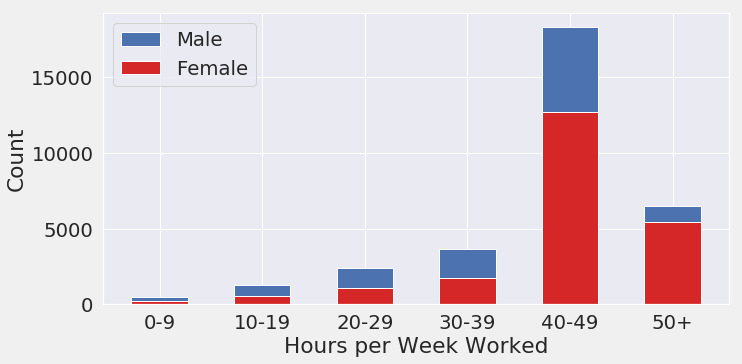

In [127]:
import matplotlib.pyplot as plt
import seaborn as sns

#Plots the bar chart
fig = plt.figure(figsize=(10, 5))
sns.set(font_scale=1.8)
categories = ["0-9","10-19","20-29","30-39","40-49","50+"]
p1 = plt.bar(categories, male_count, 0.55, color='#d62728')
p2 = plt.bar(categories, female_count, 0.55, bottom=male_count)
plt.legend((p2[0], p1[0]), ('Male', 'Female'))
plt.xlabel('Hours per Week Worked')
plt.ylabel('Count')
plt.show()

## Expected Value Calculation
\begin{align}
expected_{i,j} =\frac{(row_{i} \text{total})(column_{j} \text{total}) }{(\text{total observations})}  
\end{align}

In [67]:
# Get row sums
row_sums = contingency_table.iloc[0:2,6].values
col_sums = contingency_table.iloc[2,0:6].values
print(row_sums)
print(col_sums)

[10771 21790]
[  458  1246  2392  3667 18336  6462]


In [68]:
total_obs = contingency_table.loc['All','All']
total_obs

32561

In [69]:
expected = []

for i in range(len(row_sums)):
  expected_row = []
  for column in col_sums:
    expected_val = row_sums[i] * column / total_obs
    expected_row.append(expected_val)
  expected.append(expected_row)

print(np.array(expected))

[[  151.50388502   412.16995793   791.26046497  1213.02346365
   6065.44811277  2137.59411566]
 [  306.49611498   833.83004207  1600.73953503  2453.97653635
  12270.55188723  4324.40588434]]


In [70]:
observed = pd.crosstab(df['sex'], df['hours_per_week_categories'])
observed

hours_per_week_categories,0-9,10-19,20-29,30-39,40-49,50+
sex,,,,,,
Female,235,671,1287,1914,5636,1028
Male,223,575,1105,1753,12700,5434


In [71]:
observed = observed.values
observed

array([[  235,   671,  1287,  1914,  5636,  1028],
       [  223,   575,  1105,  1753, 12700,  5434]])

## Chi-Squared Statistic with Numpy

\begin{align}
\chi^2 = \sum \frac{(observed_{i}-expected_{i})^2}{(expected_{i})}
\end{align}

For the $observed$ values we will just use a version of our contingency table without the margins as a numpy array. In this way, if our observed values array and our expected values array are the same shape, then we can subtract them and divide them directly which makes the calculations a lot cleaner. No for loops!

In [72]:
chi_squ = ((observed-expected)**2/expected).sum()
print(f'Chi-Squared: {chi_squ}')

Chi-Squared: 2287.190943926107


In [73]:
# calculate degress of freedom

dof = (len(row_sums)-1)*(len(col_sums)-1)
print(f'Degrees of Freedom: {dof}')

Degrees of Freedom: 5


In [77]:
chi_squ, p_value, dof, expected = stats.chi2_contingency(observed)

print(f'Chi-Squared: {chi_squ}')
print(f'P-Value: {p_value}')
print(f'Degrees of Freedom: {dof}')
print('Expected: \n', np.array(expected))

Chi-Squared: 2287.190943926107
P-Value: 0.0
Degrees of Freedom: 5
Expected: 
 [[  151.50388502   412.16995793   791.26046497  1213.02346365
   6065.44811277  2137.59411566]
 [  306.49611498   833.83004207  1600.73953503  2453.97653635
  12270.55188723  4324.40588434]]


## Confidence Interval Example

In [18]:
# confidence_interval = [lower_bound, upper_bound]

coinflips = np.random.binomial(n=1, p=.5, size=100)
print(coinflips)

[1 1 0 0 0 1 0 0 0 0 0 0 1 0 1 1 0 1 0 1 1 1 0 0 1 0 0 1 0 0 0 1 0 0 0 1 1
 0 1 0 1 0 0 1 0 1 1 0 0 0 1 1 0 1 0 0 1 1 0 1 0 1 1 0 0 0 0 0 1 0 1 1 1 1
 1 0 1 1 0 1 0 1 0 0 0 1 1 0 1 1 0 1 0 1 1 1 0 0 1 1]


In [20]:
coinflips.mean()

0.48

In [21]:
stats.ttest_1samp(coinflips, .5)

Ttest_1sampResult(statistic=-0.39831375340784614, pvalue=0.6912566363051549)

In [23]:
coinflips_100 = np.random.binomial(n=1, p=.5, size=100)
coinflips_1000 = np.random.binomial(n=1, p=.5, size=1000)

print('100 coinflips mean:', coinflips_100.mean())
print('1000 coinflips mean:', coinflips_1000.mean())

print('100 coinflips std:', np.std(coinflips_100))
print('1000 coinflips std:', np.std(coinflips_1000))

100 coinflips mean: 0.49
1000 coinflips mean: 0.487
100 coinflips std: 0.4998999899979995
1000 coinflips std: 0.49983097142934235


In [24]:
print('100 coinflips standard error:', stats.sem(coinflips_100))
print('1000 coinflips standard error:', stats.sem(coinflips_1000))

100 coinflips standard error: 0.05024183937956914
1000 coinflips standard error: 0.01581395210189664


## Confidence Interval Equation
![confidence interval equation](https://www.statisticshowto.datasciencecentral.com/wp-content/uploads/2009/10/t-dist.jpg)

In [0]:
import numpy as np
from scipy import stats

def confidence_interval(data, confidence=0.95):
  """
  Calculate a confidence interval around a sample mean for given data.
  Using t-distribution and two-tailed test, default 95% confidence.
  
  Arguments:
    data - iterable (list or numpy array) of sample observations
    confidence - level of confidence for the interval
    
  Returns:
    tuple of (mean, lower bound, upper bound)
  """
  
  data = np.array(data)
  mean = np.mean(data)
  n = len(data)
  stderr = stats.sem(data)
  interval = stderr * stats.t.ppf((1 + confidence) / 2.0, n - 1)
  return (mean, mean - interval, mean + interval)

def report_confidence_interval(confidence_interval):
  """
  Return a string with a pretty report of a confidence interval.
  
  Arguments:
    confidence_interval - tuple of (mean, lower bound, upper bound)
    
  Returns:
    None, but prints to screeen the report
  """
  
  s = 'Our mean lies in the interval [{:.5}, {:.5}]'.format(
      confidence_interval[1], confidence_interval[2])
  return s 

In [86]:
report_confidence_interval(confidence_interval(coinflips_100))

'Our mean lies in the interval [0.39031, 0.58969]'

In [80]:
report_confidence_interval(confidence_interval(coinflips_1000))

'Our mean lies in the interval [0.45597, 0.51803]'

In [87]:
stats.t.ppf(0.05, 5) # p-value, dof

-2.0150483726691575

## Assignment - Build a confidence interval

A confidence interval refers to a neighborhood around some point estimate, the size of which is determined by the desired p-value. For instance, we might say that 52% of Americans prefer tacos to burritos, with a 95% confidence interval of +/- 5%.

52% (0.52) is the point estimate, and +/- 5% (the interval $[0.47, 0.57]$) is the confidence interval. "95% confidence" means a p-value $\leq 1 - 0.95 = 0.05$.

In this case, the confidence interval includes $0.5$ - which is the natural null hypothesis (that half of Americans prefer tacos and half burritos, thus there is no clear favorite). So in this case, we could use the confidence interval to report that we've failed to reject the null hypothesis.

But providing the full analysis with a confidence interval, including a graphical representation of it, can be a helpful and powerful way to tell your story. Done well, it is also more intuitive to a layperson than simply saying "fail to reject the null hypothesis" - it shows that in fact the data does *not* give a single clear result (the point estimate) but a whole range of possibilities.

How is a confidence interval built, and how should it be interpreted? It does *not* mean that 95% of the data lies in that interval - instead, the frequentist interpretation is "if we were to repeat this experiment 100 times, we would expect the average result to lie in this interval ~95 times."

For a 95% confidence interval and a normal(-ish) distribution, you can simply remember that +/-2 standard deviations contains 95% of the probability mass, and so the 95% confidence interval based on a given sample is centered at the mean (point estimate) and has a range of +/- 2 (or technically 1.96) standard deviations.

Different distributions/assumptions (90% confidence, 99% confidence) will require different math, but the overall process and interpretation (with a frequentist approach) will be the same.

Your assignment - using the data from the prior module ([congressional voting records](https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records)):

1. Generate and numerically represent a confidence interval
2. Graphically (with a plot) represent the confidence interval
3. Interpret the confidence interval - what does it tell you about the data and its distribution?

Stretch goals:

1. Write a summary of your findings, mixing prose and math/code/results. *Note* - yes, this is by definition a political topic. It is challenging but important to keep your writing voice *neutral* and stick to the facts of the data. Data science often involves considering controversial issues, so it's important to be sensitive about them (especially if you want to publish).
2. Apply the techniques you learned today to your project data or other data of your choice, and write/discuss your findings here.
3. Refactor your code so it is elegant, readable, and can be easily run for all issues.

In [0]:
# TODO - your code!
# histogram w/ error bars(whiskers)

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, ttest_ind_from_stats, ttest_rel, ttest_1samp

# ttest_ind - 2 function T test
# ttest_1samp - 1 function(sample) T test
# chi-squares - categorical comparison
# t-test - comparing means, samples

In [96]:
# load and clean data
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data', header=None)
df.columns = ["party", "handicapped-infants", "water-project-cost-sharing"
              , "adoption-of-the-budget-resolution", "physician-fee-freeze"
              , "el-salvador-aid", "religious-groups-in-schools"
              , "anti-satellite-test-ban", "aid-to-nicaraguan-contras"
              , "mx-missile", "immigration", "synfuels-corporation-cutback"
              , "education-spending", "superfund-right-to-sue", "crime"
              , "duty-free-exports", "export-administration-act-south-africa"
             ]
df = df.replace({'n':0.0,'y':1.0,'?':np.nan})

rep = df[df['party']=='republican']
dem = df[df['party']=='democrat']

print(df.shape)
df.head()

(435, 17)


,party,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
0,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,0.0,1.0
1,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,NaN
2,democrat,NaN,1.0,1.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
3,democrat,0.0,1.0,1.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,democrat,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,1.0


In [0]:
rep_plot = rep.drop(['party'], axis=1)
dem_plot = dem.drop(['party'], axis=1)

In [0]:
sns.set(style="whitegrid")

ax = sns.violinplot(x=rep_plot.values, y=rep_plot.columns, data=rep_plot)

In [0]:
def confidence_interval(data, confidence=0.95):
  """
  Calculate a confidence interval around a sample mean for given data.
  Using t-distribution and two-tailed test, default 95% confidence.
  
  Arguments:
    data - iterable (list or numpy array) of sample observations
    confidence - level of confidence for the interval
    
  Returns:
    tuple of (mean, lower bound, upper bound)
  """
  
  data = np.array(data)
  mean = np.mean(data)
  n = len(data)
  stderr = stats.sem(data)
  interval = stderr * stats.t.ppf((1 + confidence) / 2.0, n - 1)
  return (mean, mean - interval, mean + interval, interval)

def say_confidence_interval(confidence_interval):
  """
  Return a string with a pretty report of a confidence interval.
  
  Arguments:
    confidence_interval - tuple of (mean, lower bound, upper bound)
    
  Returns:
    None, but prints to screeen the report
  """
  
  s = 'With 95% confidence interval within [{:.4}, {:.4}]'.format(
      confidence_interval[1]*100, confidence_interval[2]*100)
  return s 

In [136]:
df_plot = pd.DataFrame({'party': ['democrat','republican']})
df_plot

,party
0,democrat
1,republican


In [144]:
# df_plot = df_plot.drop(['handicapped-infants'], axis=1)
df_plot

,party,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
0,democrat,60.465116,50.209205,88.846154,5.405405,21.568627,47.674419,77.220077,82.889734,75.806452,47.148289,50.588235,14.457831,28.968254,35.019455,63.745020,93.513514
1,republican,18.787879,50.675676,13.414634,98.787879,95.151515,89.759036,24.074074,15.286624,11.515152,55.757576,13.207547,87.096774,86.075949,98.136646,8.974359,65.753425


In [0]:
dem_means, rep_means, dem_moe, rep_moe

In [159]:
dem_means = []
rep_means = []
dem_moe = []
rep_moe = []

for col in range(len(df.columns)-1):
  issue = df.columns[col+1]
  print('Voting Issue: ' + issue)
  
  # 2 sample test, removing NaN
  t, p = ttest_ind(dem[issue], rep[issue], nan_policy='omit')
  
  # converting to array, removing NaN
  dem_array = np.array(dem[issue])[~np.isnan(np.array(dem[issue]))]
  rep_array = np.array(rep[issue])[~np.isnan(np.array(rep[issue]))]
  
  # evaluating which party supports the issue
  if p < 0.01 and dem[issue].mean() > rep[issue].mean():
    print('Significant Democrat Support: p < 0.01')
  elif p < 0.01 and dem[issue].mean() < rep[issue].mean():
    print('Significant Republican Support: p < 0.01')
  elif p > 0.1:
    print('There may not be much of a difference: p > 0.1')
    print('p-value = %0.3f' % p)
  else:
    print('Not enough certainty level.')
    print('p-value = %0.3f' % p)
  
  # reporting support %, confidence interval
  d_per = dem[issue].mean()*100
  r_per = rep[issue].mean()*100
  print("Democrat Support: %0.2f%%" % d_per)
  print(say_confidence_interval(confidence_interval(dem_array)))
  print("Republican Support: %0.2f%%" % r_per)
  print(say_confidence_interval(confidence_interval(rep_array)))
  print()
  
#   df_plot[issue] = dem[issue].mean()*100, rep[issue].mean()*100
  dem_means.append(d_per)
  rep_means.append(r_per)
  dem_moe.append(confidence_interval(dem_array)[3]*100)
  rep_moe.append(confidence_interval(rep_array)[3]*100)

Voting Issue: handicapped-infants
Significant Democrat Support: p < 0.01
Democrat Support: 60.47%
With 95% confidence interval within [54.46, 66.47]
Republican Support: 18.79%
With 95% confidence interval within [12.77, 24.81]

Voting Issue: water-project-cost-sharing
There may not be much of a difference: p > 0.1
p-value = 0.929
Democrat Support: 50.21%
With 95% confidence interval within [43.82, 56.59]
Republican Support: 50.68%
With 95% confidence interval within [42.53, 58.82]

Voting Issue: adoption-of-the-budget-resolution
Significant Democrat Support: p < 0.01
Democrat Support: 88.85%
With 95% confidence interval within [84.99, 92.7]
Republican Support: 13.41%
With 95% confidence interval within [8.144, 18.69]

Voting Issue: physician-fee-freeze
Significant Republican Support: p < 0.01
Democrat Support: 5.41%
With 95% confidence interval within [2.633, 8.178]
Republican Support: 98.79%
With 95% confidence interval within [97.1, 100.5]

Voting Issue: el-salvador-aid
Significant R

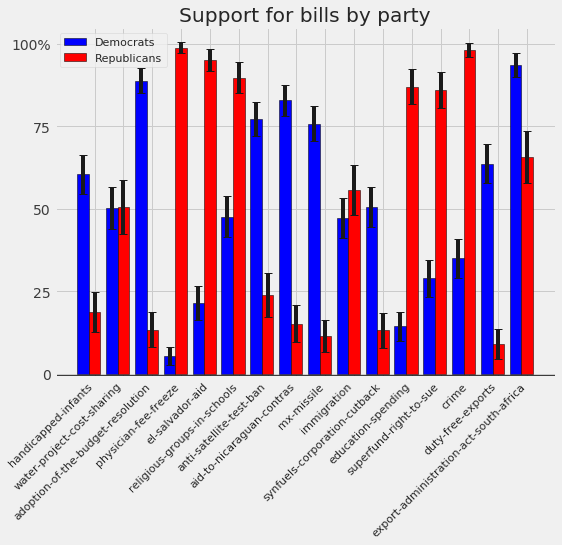

In [191]:
# plot a bar graph
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(8,6))

barWidth = 0.4

r1 = np.arange(len(dem_means))
r2 = [x + barWidth for x in r1]

plt.bar(r1, dem_means, width = barWidth, color = 'blue', edgecolor = 'black'
        , yerr = dem_moe, capsize = 4, label = 'Democrats')
plt.bar(r2, rep_means, width = barWidth, color = 'red', edgecolor = 'black'
        , yerr = rep_moe, capsize = 4, label = 'Republicans')

# title text
plt.title('Support for bills by party')

# modify y labels
ax.set_yticks([0, 25, 50, 75, 100])
ax.set_yticklabels(labels=['0','25','50','75','100%'], 
                   fontsize=14, color='#3C3C3C')

# bold y axis at 0
ax.axhline(y=-0.5, color='black', linewidth=1.5, alpha=1)
plt.ylim(-1,105)

ax.legend()

plt.xticks([r + barWidth for r in range(len(dem_means))], rep_plot.columns, rotation = 45, ha="right");

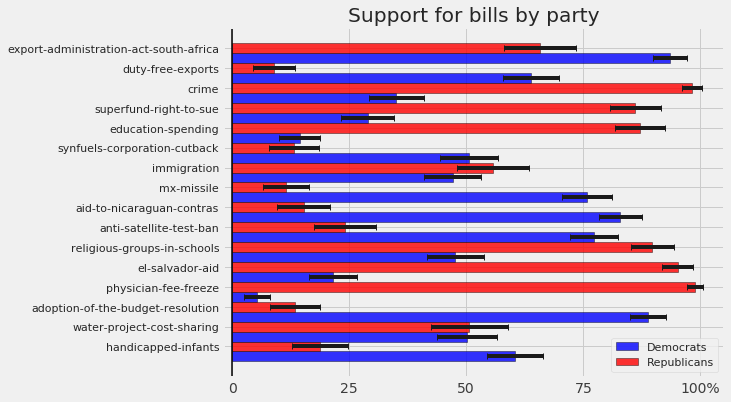

In [208]:
# plot a bar graph
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(8,6))

barWidth = 0.5

r1 = np.arange(len(dem_means))
r2 = [x + barWidth for x in r1]

ax1= ax.barh(r1, dem_means, height = barWidth, color = 'blue', edgecolor = 'black'
        , xerr = dem_moe, capsize = 3, label = 'Democrats', alpha=.8)
ax2= ax.barh(r2, rep_means, height = barWidth, color = 'red', edgecolor = 'black'
        , xerr = rep_moe, capsize = 3, label = 'Republicans', alpha=.8)

# title text
plt.title('Support for bills by party')

# modify y labels
ax.set_xticks([0, 25, 50, 75, 100])
ax.set_xticklabels(labels=['0','25','50','75','100%'], 
                   fontsize=14, color='#3C3C3C')

# bold y axis at 0
ax.axvline(x=0, color='black', linewidth=1.5, alpha=1)
plt.xlim(-2,105)

ax.legend()

plt.yticks([r + barWidth for r in range(len(dem_means))], rep_plot.columns, ha="right");

In [0]:
df_col = df.columns[1:]
ct = pd.crosstab(df['party'], df.columns[1:])
ct

In [0]:
df.columns[1:]

In [132]:
value = df.mean()
# margin of error

plt.bar(range(len(df.columns)), value+np.abs(df.values.min()), bottom=df.values.min(), 
        align='center', alpha=0.5)

plt.xticks(range(len(df.columns)), df.columns)
plt.ylabel('Stock price')
plt.title('Something')
plt.show()

TypeError: ignored

In [0]:
# set style to fivethirtyeight
plt.style.use('fivethirtyeight')

# set plot size
fig, ax = plt.subplots(figsize=(8,6))

ax.bar(x, y, width=0.5, color='b', align='center')
ax.bar(x, z, width=0.5, color='g', align='center')
ax.bar(x, k, width=0.5, color='r', align='center')

In [0]:
# set style to fivethirtyeight
plt.style.use('fivethirtyeight')

# set plot size
fig, ax = plt.subplots(figsize=(8,6))

# plot category by occupation
# ax = sns.barplot(dem.values, dem.columns, alpha=0.8)
ax = sns.violinplot(x=df_plot.values, y=df_plot.columns, hue="party", data=df_plot)
# ax = sns.violinplot(x="orbital_period", y="method"
#                     , data=planets[planets.orbital_period < 1000]
#                     , scale="width", palette="Set3")

# title text
# ax.text(x=1996.7, y=120, s="Who Got to Be On 'The Daily Show'?", fontsize=20, 
#         fontweight='semibold', family='Arial', color='#3C3C3C')

# # subtitle text
# ax.text(x=1996.7, y=114, s='Occupation of guests, by year', fontsize=17, 
#         color='#3C3C3C')

# text labels for each line
# ax.text(x=2000.5, y=80, s="Acting, Comedy & Music", fontsize=14, 
#         fontweight='semibold', color='#008FD5')
# ax.text(x=2008.3, y=6, s="Government and Politics", fontsize=14, 
#         fontweight='semibold', color='#FF2700')
# ax.text(x=2007.4, y=52.5, s="Media", fontsize=14, 
#         fontweight='semibold', color='#810F7C')
# plt.text(x = 2000.5, y = 80, s = 'Acting, Comedy & Music', color = '#008FD5', 
#            weight = 'semibold', backgroundcolor = '#f0f0f0')
# plt.text(x = 2008.3, y = 6, s = 'Government and Politics', color = '#FF2700', 
#            weight = 'semibold', backgroundcolor = '#f0f0f0');
# plt.text(x = 2007.5, y = 52.5, s = 'Media', color = '#810F7C', 
#            weight = 'semibold', backgroundcolor = '#f0f0f0')

# set y axis past 0 and 100 for extra grid line
# plt.ylim(-5,110)
# ax.tick_params(axis = 'y', labelsize = 10, length = 8, 
#                labelcolor = '#3C3C3C')

# bold y axis at 0
# ax1.axhline(y=0, color='black', linewidth=1.5, alpha=0.5)

# modify y labels
# ax.set_yticks([0, 25, 50, 75, 100])
# ax.set_yticklabels(labels=['0','25','50','75','100%'], 
#                    fontsize=14, color='#3C3C3C')


# modify x labels
# ax.set_xticks([2000, 2004, 2008, 2012])
# ax.set_xticklabels(labels=['2000',"'04","'08","'12"], 
#                    fontsize=14, color='#3C3C3C')


# signature line at bottom
# ax1.text(x = 1996.5, y = -17,
#     s = '  GEORGE                                       SOURCE: UCI Congressional Voting Records',
#     fontsize = 9, family='monospace', color = '#F0F0F0', 
#          backgroundcolor = '#5B5E5F');

## Resources

- [Interactive visualize the Chi-Squared test](https://homepage.divms.uiowa.edu/~mbognar/applets/chisq.html)
- [Calculation of Chi-Squared test statistic](https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test)
- [Visualization of a confidence interval generated by R code](https://commons.wikimedia.org/wiki/File:Confidence-interval.svg)
- [Expected value of a squared standard normal](https://math.stackexchange.com/questions/264061/expected-value-calculation-for-squared-normal-distribution) (it's 1 - which is why the expected value of a Chi-Squared with $n$ degrees of freedom is $n$, as it's the sum of $n$ squared standard normals)